# 시계열 데이터 실전에서 사용해 보기

## 예제 1. 웹 유입량 데이터 분석

> Prophet을 이용해 [핑크윈크 블로그](https://pinkwink.kr/)의 웹 유입량 데이터를 분석해 본다.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt

from prophet import Prophet
from datetime import datetime

%matplotlib inline

### 🔰 데이터 읽어오기

- Param 정보

	- thousands=","

		천단위 구분자를 제거하고 float형 숫자로 데이터를 읽어온다.
		단위 구분다가 존재하면 문자열로 인식하고 object형으로 읽어온다.

	- name=["date", "hit"]

		column title이 없는 .csv 파일이므로 별도의 name= 설정이 필요하다.

In [6]:
pinkwink_web = pd.read_csv(
	"../data/05_PinkWink_Web_Traffic.csv",
	encoding="utf-8",
	thousands=",",
	names=["date", "hit"],
	index_col=0
)
pinkwink_web

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0
...,...
17. 6. 27.,1436.0
17. 6. 28.,1387.0
17. 6. 29.,1328.0


In [5]:
pinkwink_web.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 16. 7. 1. to nan
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hit     365 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB


In [7]:
'''
 > NaN 값 제거
'''
pinkwink_web = pinkwink_web[pinkwink_web["hit"].notnull()]
pinkwink_web

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0
...,...
17. 6. 26.,1309.0
17. 6. 27.,1436.0
17. 6. 28.,1387.0


### 🔰 전체 데이터 그려보기

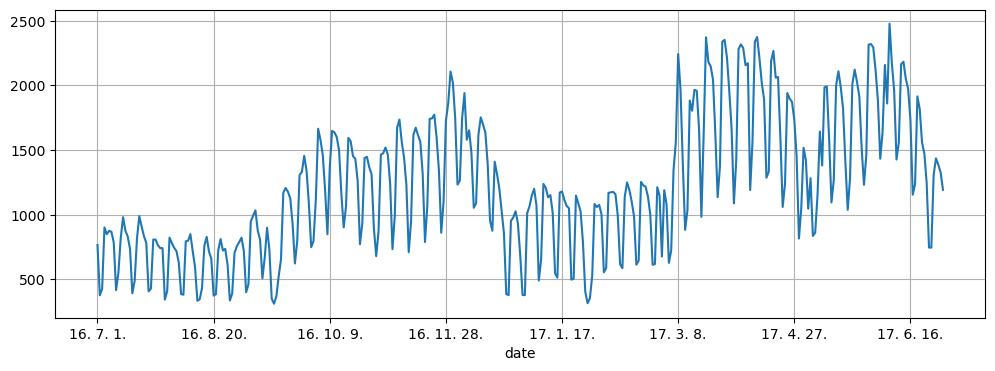

In [9]:
pinkwink_web["hit"].plot(figsize=(12, 4), grid=True);

### 🔰 경향 분석 by numpy

- 먼저 numpy를 이용해 trend를 따로 파악해 본다.

	prophet 모듈이 어떤 방식으로 예측을 하는지 알 수 없으므로 우리가 직접 경향성을 파악해 본다.

</br>

- 다항식 회귀(Polynomial Regression) 모델을 사용한다.

	다항식 회귀는 다항식 함수를 사용하여 데이터를 근사하는 회귀 모델이다.

	일반적으로 다항식은 다음과 같은 형태를 가진다.

	$ y = a_n x^n + a_{n-1} x^{n-1} + \ldots + a_2 x^2 + a_1 x + a_0 $

	- Degree of the fitting polynomial(적합 다항식의 차수)

		다항식 회귀에서, 다항식의 차수는 다항식에서 사용되는 최고 차항의 지수이다.

1. trend 분석을 시각화하기 위한 x축 값 만들기

In [11]:
len(pinkwink_web)

365

In [16]:
time = np.arange(0, len(pinkwink_web))
time

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

2. trend 분석을 시각화하기 위한 y축 값 만들기

In [17]:
traffic = pinkwink_web["hit"].values
traffic

array([ 766.,  377.,  427.,  902.,  850.,  876.,  868.,  785.,  417.,
        550.,  818.,  981.,  877.,  833.,  737.,  393.,  489.,  817.,
        989.,  908.,  835.,  782.,  408.,  429.,  808.,  808.,  765.,
        742.,  742.,  344.,  408.,  823.,  781.,  745.,  719.,  629.,
        386.,  382.,  795.,  799.,  850.,  717.,  595.,  335.,  346.,
        433.,  759.,  829.,  716.,  659.,  375.,  386.,  727.,  812.,
        723.,  736.,  613.,  337.,  391.,  704.,  757.,  788.,  823.,
        721.,  401.,  463.,  948.,  993., 1034.,  877.,  808.,  508.,
        669.,  899.,  732.,  352.,  312.,  369.,  522.,  655., 1170.,
       1207., 1178., 1126.,  929.,  623.,  799., 1307., 1331., 1455.,
       1342., 1090.,  749.,  797., 1117., 1665., 1579., 1461., 1188.,
        849., 1364., 1648., 1637., 1601., 1499., 1159.,  902., 1066.,
       1594., 1568., 1453., 1433., 1265.,  772.,  932., 1439., 1448.,
       1367., 1313.,  895.,  680.,  872., 1464., 1476., 1520., 1464.,
       1239.,  734.,

3. trend 파악을 위한 함수 생성

- `np.polyfit()`

	다항식을 데이터에 적합시키는 함수로 데이터에 적합한 다항식 계수(polynomial coefficients)를 반환한다.
	
	- x: 독립 변수 값.
		- "hit" value와 동일한 길이의 임의 데이터 생성

	- y: 종속 변수 값.
		- "hit" values

	- deg: 다항식의 차수.
		- 1차, 2차, 3차, 15차 함수까지 생성

	- rcond, full, w, cov: 추가적인 매개변수.

In [20]:
np.polyfit(time, traffic, 1), np.polyfit(time, traffic, 15)

(array([  2.94751137, 678.39950595]),
 array([ 2.37543322e-29, -6.18482389e-26,  7.30047482e-23, -5.16077059e-20,
         2.42917258e-17, -8.00159267e-15,  1.88603715e-12, -3.19726209e-10,
         3.86603608e-08, -3.26709985e-06,  1.87092739e-04, -7.04463373e-03,
         1.76801765e-01, -3.15303469e+00,  3.27803992e+01,  6.17394607e+02]))

In [26]:
pf1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(pf1)

pf2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(pf2)

pf3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(pf3)

pf15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(pf15)

- trend 함수 시각화

In [22]:
time[-1] # time의 마지막 요소값

364

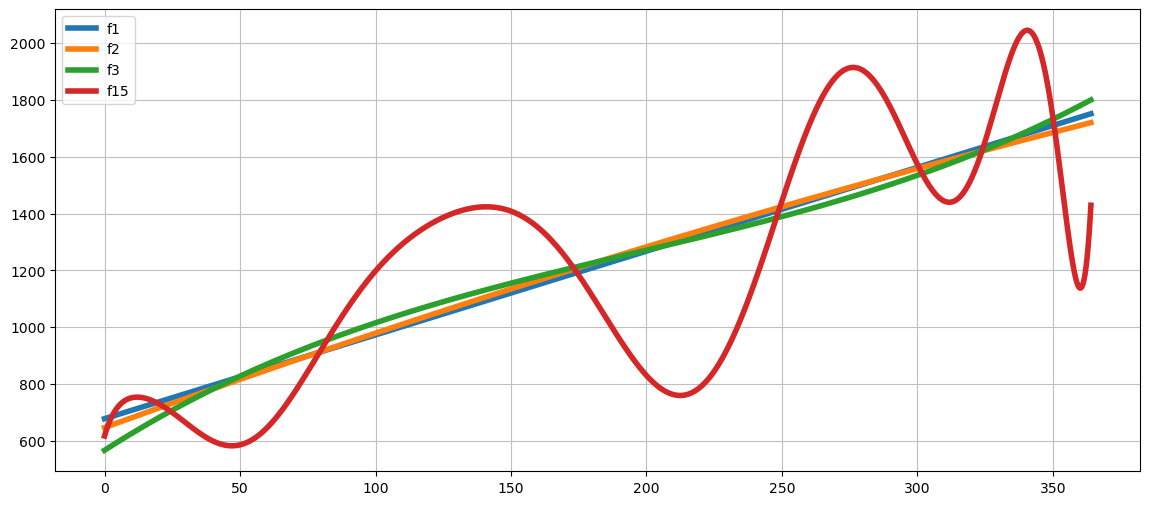

In [28]:
fx = np.linspace(0, time[-1], 1000) # 0 ≤ fx ≤ 364

plt.figure(figsize=(14, 6))
plt.plot(fx, f1(fx), lw=4, label='f1') # line width: 선의 굵기
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle="-", color="0.75")
plt.legend(loc=2)
plt.show()

- 오차 검증 : RMSE

	우리가 만든 경향성 모델이 얼마나 정확한지 확인해줄 지표로 RMSE(rmse average, 제곱근오차평균)을 사용한다.

- `error()`

	- numpy로 계산한 경향성과 실제 데이터의 오차가 얼마인지 확인해줄 error 함수 생성

	- f: trend 함수

	- y: 실제 데이터(관측값), 여기선 pinkwink_df의 "hit" 값

	- 오차값이 작을수록 정확한 모델이다.


In [29]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x) - y) ** 2))

In [30]:
print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.85973081109626
430.6284101894695
429.5328046676293
330.47773079342267


- np trend와 실제 데이터 비교

	numpy로 만든 trend 함수들과 실제 데이터를 그래프로 확인해 본다.

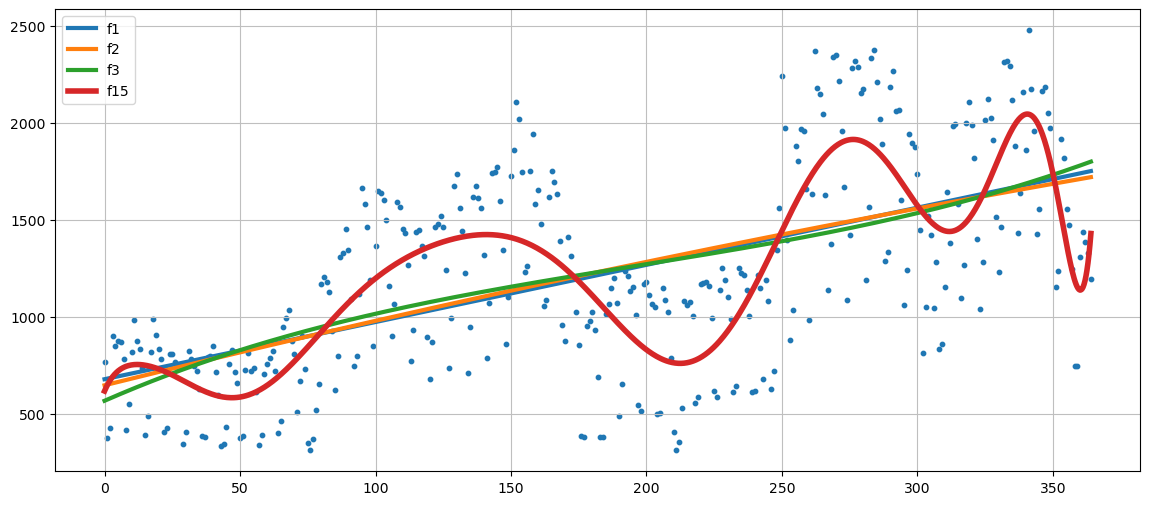

In [32]:
plt.figure(figsize=(14, 6))
'''
 > 실제 데이터 : PinkWink 블로그 웹 유입량
'''
plt.scatter(time, traffic, s=10)
'''
 > 경향 데이터 : numpy로 구한 trend 함수
'''
plt.plot(fx, f1(fx), lw=3, label='f1') # line width: 선의 굵기
plt.plot(fx, f2(fx), lw=3, label='f2')
plt.plot(fx, f3(fx), lw=3, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle="-", color="0.75")
plt.legend(loc=2)
plt.show()

👉 결론

실제 데이터 분포와 가장 경향성이 유사해 보이는 함수는 f15이다. 
error() 함수로 검증한 값도 f15 오차값이 가장 작았다.

### 🔰 경향 분석 by prophet

- Prophet을 이용해 경향성을 분석하고 미래 데이터를 얻어본다.

- DataFrame 생성

	Prophet에 학습시킬 데이터프레임 형식으로 웹 유입량 데이터를 변형시켜 준다.

In [33]:
pinkwink_web

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0
...,...
17. 6. 26.,1309.0
17. 6. 27.,1436.0
17. 6. 28.,1387.0


In [34]:
df = pd.DataFrame({"ds": pinkwink_web.index, "y": pinkwink_web["hit"]})
df

,ds,y
date,,
16. 7. 1.,16. 7. 1.,766.0
16. 7. 2.,16. 7. 2.,377.0
16. 7. 3.,16. 7. 3.,427.0
16. 7. 4.,16. 7. 4.,902.0
16. 7. 5.,16. 7. 5.,850.0
...,...,...
17. 6. 26.,17. 6. 26.,1309.0
17. 6. 27.,17. 6. 27.,1436.0
17. 6. 28.,17. 6. 28.,1387.0


In [35]:
df.reset_index(inplace=True)
df

,date,ds,y
0,16. 7. 1.,16. 7. 1.,766.0
1,16. 7. 2.,16. 7. 2.,377.0
2,16. 7. 3.,16. 7. 3.,427.0
3,16. 7. 4.,16. 7. 4.,902.0
4,16. 7. 5.,16. 7. 5.,850.0
...,...,...,...
360,17. 6. 26.,17. 6. 26.,1309.0
361,17. 6. 27.,17. 6. 27.,1436.0
362,17. 6. 28.,17. 6. 28.,1387.0
363,17. 6. 29.,17. 6. 29.,1328.0


In [36]:
'''
 > "date" 컬럼 삭제하고 "ds" 날짜 포맷 변경
'''
del df["date"]
df["ds"] = pd.to_datetime(df["ds"], format="%y. %m. %d.")
df.head()

,ds,y
0,2016-07-01,766.0
1,2016-07-02,377.0
2,2016-07-03,427.0
3,2016-07-04,902.0
4,2016-07-05,850.0


- model 생성

In [37]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)

- model에 데이터 학습시키기

In [38]:
model.fit(df);

18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing


- model로 데이터 예측

	향후 60일에 해당하는 데이터 예측

	예측 결과는 상한/하한의 범위를 포함해서 얻어진다.

In [39]:
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-01,823.686718,523.231004,933.487035,823.686718,823.686718,-98.127797,-98.127797,-98.127797,232.493202,232.493202,232.493202,-51.470071,-51.470071,-51.470071,-279.150927,-279.150927,-279.150927,0.0,0.0,0.0,725.558921
1,2016-07-02,824.549075,91.276403,519.320606,824.549075,824.549075,-529.179402,-529.179402,-529.179402,232.493202,232.493202,232.493202,-467.269682,-467.269682,-467.269682,-294.402921,-294.402921,-294.402921,0.0,0.0,0.0,295.369673
2,2016-07-03,825.411431,186.924055,622.616990,825.411431,825.411431,-409.285386,-409.285386,-409.285386,232.493202,232.493202,232.493202,-335.192360,-335.192360,-335.192360,-306.586228,-306.586228,-306.586228,0.0,0.0,0.0,416.126045
3,2016-07-04,826.273788,745.414450,1189.451345,826.273788,826.273788,133.829867,133.829867,133.829867,232.493202,232.493202,232.493202,217.266040,217.266040,217.266040,-315.929375,-315.929375,-315.929375,0.0,0.0,0.0,960.103655
4,2016-07-05,827.136145,764.256425,1216.848391,827.136145,827.136145,163.164278,163.164278,163.164278,232.493202,232.493202,232.493202,253.373817,253.373817,253.373817,-322.702741,-322.702741,-322.702741,0.0,0.0,0.0,990.300423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,2017-08-25,1191.703116,732.449852,1133.241171,1191.624915,1191.779690,-269.849921,-269.849921,-269.849921,232.493202,232.493202,232.493202,-51.470071,-51.470071,-51.470071,-450.873052,-450.873052,-450.873052,0.0,0.0,0.0,921.853195
421,2017-08-26,1192.583970,288.130344,716.732821,1192.502298,1192.662606,-685.629062,-685.629062,-685.629062,232.493202,232.493202,232.493202,-467.269682,-467.269682,-467.269682,-450.852581,-450.852581,-450.852581,0.0,0.0,0.0,506.954908
422,2017-08-27,1193.464824,434.095677,853.067547,1193.380294,1193.546102,-554.010531,-554.010531,-554.010531,232.493202,232.493202,232.493202,-335.192360,-335.192360,-335.192360,-451.311372,-451.311372,-451.311372,0.0,0.0,0.0,639.454293
423,2017-08-28,1194.345677,976.223345,1398.531243,1194.258304,1194.428484,-2.401629,-2.401629,-2.401629,232.493202,232.493202,232.493202,217.266040,217.266040,217.266040,-452.160870,-452.160870,-452.160870,0.0,0.0,0.0,1191.944049


- 예측 결과 시각화

	- 다양한 정보 중 x축, y축 값과 상한, 하한 값 선택

In [40]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,921.853195,732.449852,1133.241171
421,2017-08-26,506.954908,288.130344,716.732821
422,2017-08-27,639.454293,434.095677,853.067547
423,2017-08-28,1191.944049,976.223345,1398.531243
424,2017-08-29,1227.806799,1024.281406,1444.086167


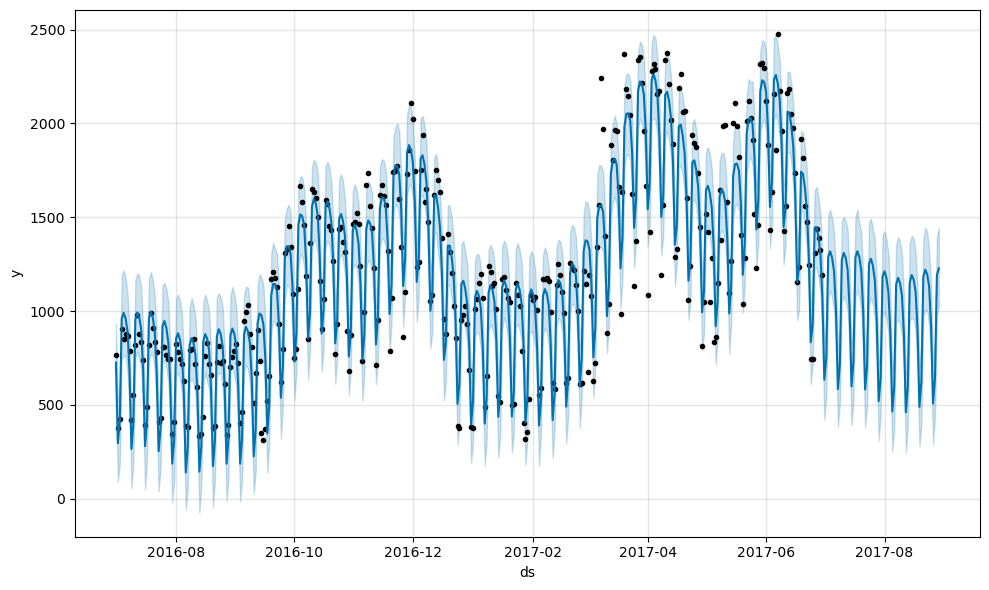

In [67]:
model.plot(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]);

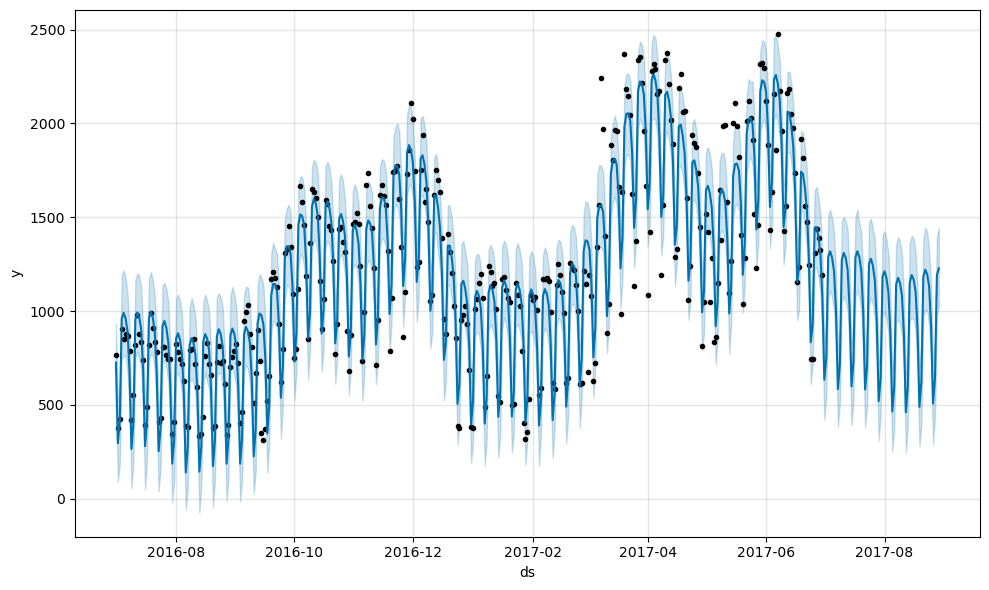

In [42]:
model.plot(forecast);

- trend 분석

	- `Prophet.plot_components()` : 미래 예측 데이터를 포함해 경향을 분석해준다.

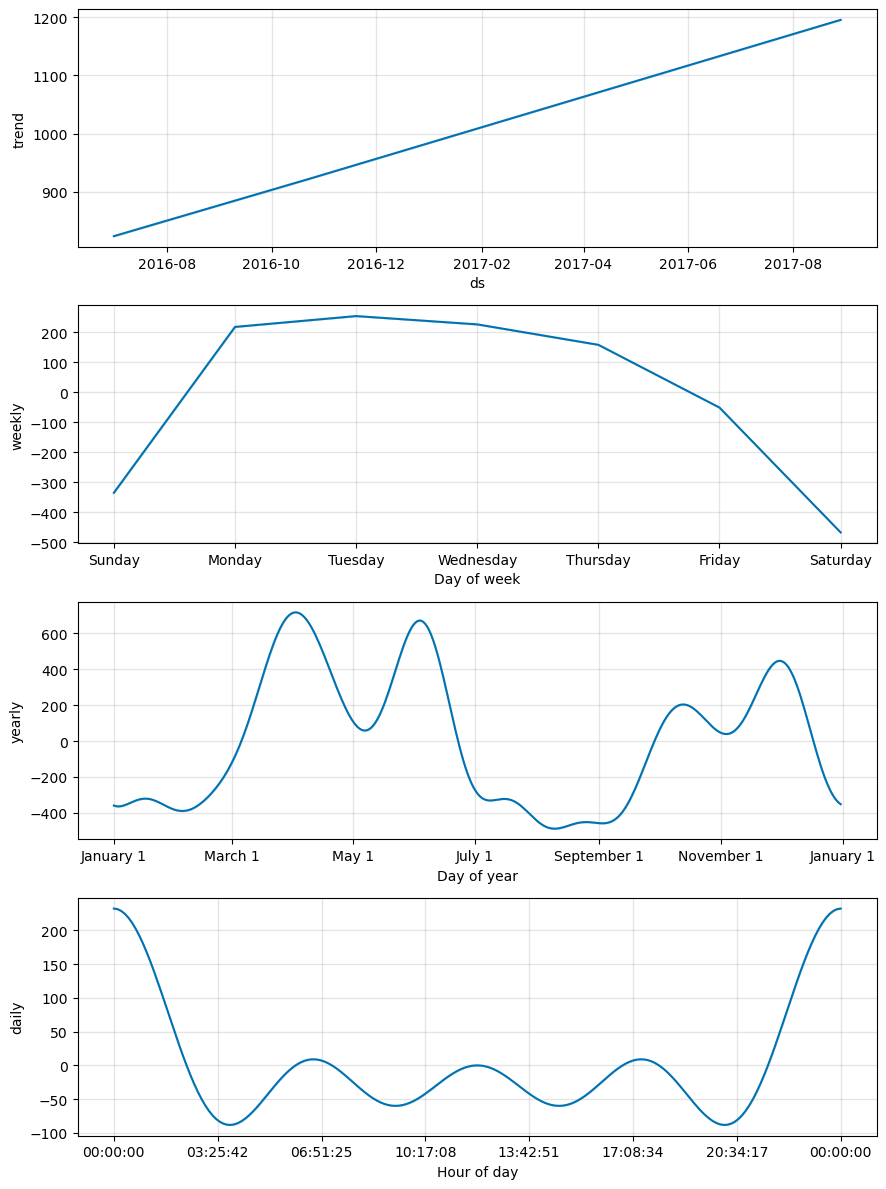

In [43]:
model.plot_components(forecast);

- 오차 검증 : RMSE

In [66]:
np.sqrt(np.mean((forecast["trend"]-df["y"])**2))

536.0321309635455

👉 결론

Prophet이 분석한 경향은 실제 데이터 분포와 상당한 오차가 존재하는 편이다.

In [44]:
df["y"]

0       766.0
1       377.0
2       427.0
3       902.0
4       850.0
        ...  
360    1309.0
361    1436.0
362    1387.0
363    1328.0
364    1193.0
Name: y, Length: 365, dtype: float64

In [50]:
forecast["yhat"]

0       725.558921
1       295.369673
2       416.126045
3       960.103655
4       990.300423
          ...     
420     921.853195
421     506.954908
422     639.454293
423    1191.944049
424    1227.806799
Name: yhat, Length: 425, dtype: float64

In [51]:
forecast["yhat"] - df["y"]

0      -40.441079
1      -81.630327
2      -10.873955
3       58.103655
4      140.300423
          ...    
420           NaN
421           NaN
422           NaN
423           NaN
424           NaN
Length: 425, dtype: float64

In [52]:
(forecast["yhat"] - df["y"]) ** 2

0       1635.480846
1       6663.510294
2        118.242897
3       3376.034690
4      19684.208643
           ...     
420             NaN
421             NaN
422             NaN
423             NaN
424             NaN
Length: 425, dtype: float64

In [53]:
np.mean((forecast["yhat"] - df["y"]) ** 2)

26978.380241517556

In [54]:
np.sqrt(np.mean((forecast["yhat"] - df["y"]) ** 2))

164.25096724682493

In [56]:
forecast.loc[:364, "yhat"] - df["y"]

0      -40.441079
1      -81.630327
2      -10.873955
3       58.103655
4      140.300423
          ...    
360    135.574951
361     12.608107
362      5.192068
363    -29.174696
364   -125.103467
Length: 365, dtype: float64

In [57]:
np.sqrt(np.mean((forecast.loc[:364, "yhat"] - df["y"])**2))

164.2509672468249

### 🔰 종합 분석

In [69]:
forecast.loc[:364, "trend"].values, len(forecast.loc[:364, "trend"].values)

(array([ 823.686718  ,  824.54907466,  825.41143132,  826.27378799,
         827.13614465,  827.99850131,  828.86085797,  829.72321463,
         830.5855713 ,  831.44792796,  832.31028462,  833.17264128,
         834.03499795,  834.89735462,  835.7597113 ,  836.62206797,
         837.48442465,  838.34678133,  839.209138  ,  840.07149468,
         840.93385136,  841.79620803,  842.65856471,  843.52092138,
         844.38327812,  845.24563485,  846.10799158,  846.97034831,
         847.83270505,  848.69506178,  849.55741851,  850.41977524,
         851.28213198,  852.14448871,  853.00684544,  853.86920217,
         854.73155894,  855.5939157 ,  856.45627247,  857.31862923,
         858.18098599,  859.04334276,  859.90569952,  860.76805629,
         861.63041305,  862.49276982,  863.35512658,  864.21748334,
         865.07984022,  865.94219709,  866.80455396,  867.66691084,
         868.52926771,  869.39162458,  870.25398145,  871.11633833,
         871.9786952 ,  872.84105207,  873.70340

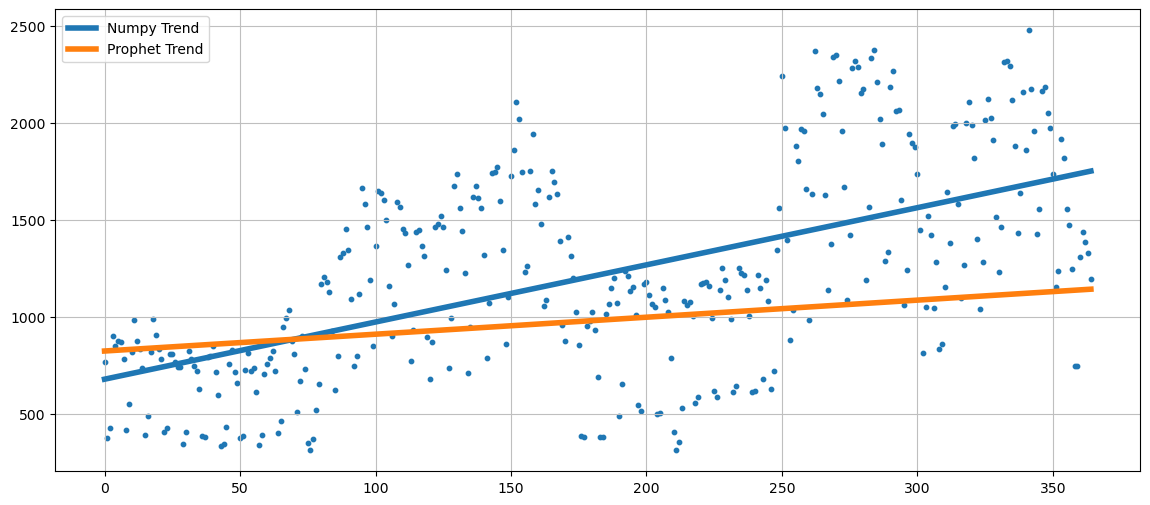

In [73]:
plt.figure(figsize=(14, 6))
'''
 > 실제 데이터 : PinkWink 블로그 웹 유입량
'''
plt.scatter(time, traffic, s=10)
'''
 > 경향 데이터 : numpy로 구한 trend 함수
'''
plt.plot(fx, f1(fx), lw=4, label='Numpy Trend')
'''
 > 경향 데이터 : prophet이 분석한 trend 값
'''
ptrend = forecast.loc[:364, "trend"].values
plt.plot(time, ptrend, lw=4, label='Prophet Trend')

plt.grid(True, linestyle="-", color="0.75")
plt.legend(loc=2)
plt.show()